## Topic Modeling: Latent Semantic Analysis/Indexing

### Imports

In [6]:
import warnings
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [7]:
% matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

## Load BBC data

In [8]:
path = Path('bbc')
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        _, topic, file_name = file.parts

        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic, heading, body])

### Convert to DataFrame

In [9]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
topic      0 non-null object
heading    0 non-null object
article    0 non-null object
dtypes: object(3)
memory usage: 0.0+ bytes


## Create Train & Test Sets

In [32]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.topic, 
                                         test_size=50, 
                                         random_state=42)

In [33]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [34]:
pd.Series(test_docs.topic).value_counts()

sport            12
business         11
politics          9
entertainment     9
tech              9
Name: topic, dtype: int64

### Vectorize train & test sets

In [35]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words='english', 
                             max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

<2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 178873 stored elements in Compressed Sparse Row format>

In [36]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 3890 stored elements in Compressed Sparse Row format>

## Latent Semantic Analysis

In [37]:
svd = TruncatedSVD(n_components=5, n_iter=20, random_state=42)
svd.fit(train_dtm)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=20,
       random_state=42, tol=0.0)

### Explore Topics 

In [38]:
topic_labels = ['Topic {}'.format(i) for i in range(1, 6)]

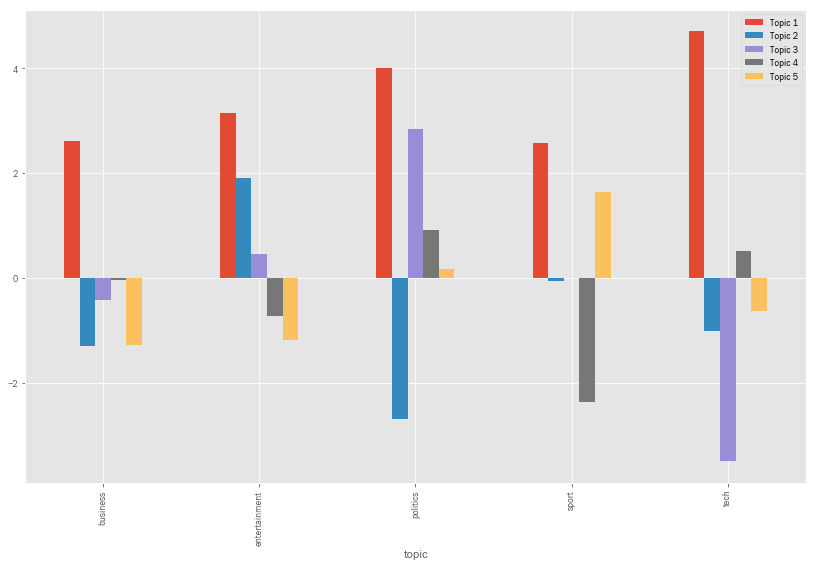

In [39]:
svd_result = pd.DataFrame(data=svd.transform(train_dtm),
                   columns=topic_labels,
                   index=train_docs.topic)
svd_result.groupby(level='topic').mean().plot.bar();

In [40]:
topics = pd.DataFrame(svd.components_.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
10,0.07,-0.00,-0.01,-0.01,-0.01
100,0.02,-0.01,-0.02,0.01,-0.01
100m,0.00,0.00,0.00,-0.01,-0.00
11,0.03,-0.00,-0.00,-0.02,-0.02
12,0.03,-0.01,-0.02,-0.02,-0.00


In [41]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,music,best,labour,music,music
1,best,music,party,urban,game
2,think,song,best,labour,urban
3,good,25,election,party,games
4,song,awards,blair,election,england
5,game,robbie,brown,black,roddick
6,labour,urban,song,mobile,play
7,british,won,minister,blair,wales
8,games,film,kilroy,stone,black
9,mobile,award,prime,digital,party


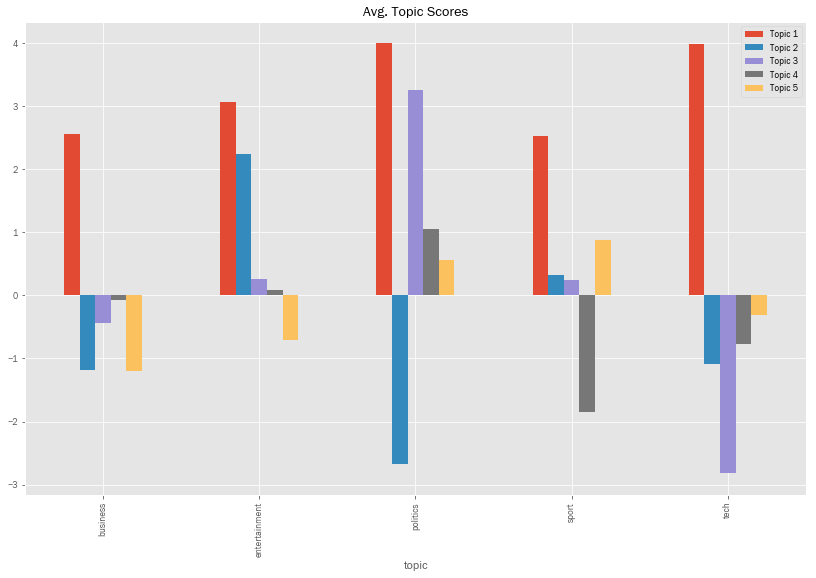

In [42]:
test_eval = pd.DataFrame(data=svd.transform(test_dtm), 
                         columns=topic_labels,
                         index=test_docs.topic)

test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Scores');